#FAST FOURIER TRANSFORM

[VSB Power Line Fault Detection](https://www.kaggle.com/competitions/vsb-power-line-fault-detection/data)

**Mô tả về dữ liệu:**

- Problem: xử lý các sự cố trong các đường dây truyền tải điện, dẫn đến hiện tượng phóng điện một phần. Nếu không được giải quyết, phóng điện một phần có thể gây hại nghiêm trọng cho thiết bị, có thể dẫn đến hỏng hoàn toàn. Thách thức là phát hiện các phóng điện một phần sớm, cho phép sửa chữa kịp thời và ngăn chặn hư hại nghiêm trọng.

- Signal data: mỗi tín hiệu được ghi lại bao gồm 800,000 lần đo điện áp được thực hiện từ một đường dây điện trong thời gian 20 mili giây. Vì lưới điện hoạt động với tần số 50 Hz, thời gian này bao gồm một chu kỳ hoàn chỉnh của lưới điện. Dữ liệu cũng phản ánh hệ thống điện 3 pha, có nghĩa là cả ba pha đều được giám sát đồng thời.

**Mô tả về features:**

- metadata_[train/test].csv:

  - `id_measurement`: mã ID cho bộ ba tín hiệu được ghi cùng lúc.
  - `signal_id`: định danh duy nhất cho mỗi tín hiệu, phân biệt giữa bộ dữ liệu train và test. Các ID là tuần tự nhưng riêng biệt cho train và test (bắt đầu từ '0' cho train và '8712' cho test).
  - `phase`: mã ID pha trong bộ ba tín hiệu. Các pha có thể bị ảnh hưởng hoặc không bởi sự cố trên đường dây.
  - `target`: Chỉ ra điều kiện của pha '0' nếu không có lỗi và '1' nếu phát hiện lỗi trong đường dây.
- [train/test].parquet: lưu trữ dữ liệu tín hiệu thực tế. Mỗi cột trong tệp Parquet đại diện cho một tín hiệu chứa 800,000 lần đo, được lưu trữ dưới dạng kiểu dữ liệu int8. Tệp Parquet được cấu trúc để tải dữ liệu lớn một cách hiệu quả, đặc biệt hữu ích cho việc truy cập một phần dữ liệu mà không cần tải toàn bộ tệp vào bộ nhớ.

## Mount drive and Import libraries

Vì data khá lớn nên nhóm em đã lưu ở drive.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
from numpy.fft import *
import pyarrow.parquet as pq
import matplotlib.pyplot as plt

sns.set_style("whitegrid")

## 1. Loading data


**1.1 Tải dữ liệu từ file train.parquet vào biến signals dưới dạng DataFrame của Pandas.**

- Hàm `pq.read_table`: đọc dữ liệu từ file Parquet (Parquet là một định dạng lưu trữ cột hiệu quả cho Hadoop, thường được sử dụng trong xử lý dữ liệu lớn do khả năng nén cao và đọc/ghi nhanh).

- Tham số `columns=[str(i) for i in range(999)]`: chỉ định danh sách các cột để đọc vào, từ cột '0' đến cột '998'.

- `.to_pandas()`: chuyển đổi kết quả đọc được thành DataFrame Pandas.

In [3]:
signals = pq.read_table('/content/drive/MyDrive/Colab Notebooks/train.parquet', columns=[str(i) for i in range(999)]).to_pandas()
signals

,0,1,2,3,4,5,6,7,8,9,...,989,990,991,992,993,994,995,996,997,998
0,18,1,-19,-16,-5,19,-15,15,-1,-16,...,4,-18,10,9,18,-20,1,18,-19,-6
1,18,0,-19,-17,-6,19,-17,16,0,-15,...,1,-20,8,8,20,-19,2,18,-18,-6
2,17,-1,-20,-17,-6,19,-17,15,-3,-15,...,1,-20,6,6,17,-22,0,18,-18,-6
3,18,1,-19,-16,-5,20,-16,16,0,-15,...,3,-21,5,6,18,-19,1,18,-18,-6
4,18,0,-19,-16,-5,20,-17,16,-2,-14,...,3,-20,5,6,19,-21,1,19,-18,-5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
799995,19,2,-18,-15,-4,21,-16,16,-1,-17,...,-1,-21,6,6,16,-19,1,20,-17,-5
799996,19,1,-19,-15,-4,20,-17,15,-3,-18,...,1,-21,6,6,15,-21,1,20,-18,-5
799997,17,0,-19,-15,-4,21,-16,14,-2,-18,...,4,-19,7,8,16,-19,1,19,-17,-5
799998,19,1,-18,-14,-3,22,-16,17,-1,-17,...,0,-19,8,8,16,-19,1,20,-18,-6


**1.2. Reshape dữ liệu tín hiệu để phù hợp với việc phân tích. Mỗi tín hiệu được ghi lại trong một cột của DataFrame, và mỗi tín hiệu chứa 800,000 điểm dữ liệu.**

- `np.array(signals)`: Chuyển DataFrame signals thành một mảng NumPy.

- `.T`: Chuyển vị (transpose) mảng để cột trở thành hàng và ngược lại. Thay đổi cách dữ liệu được tổ chức từ "cột theo tín hiệu" sang "hàng theo tín hiệu".

- `.reshape((999//3, 3, 800000))`: Dùng để tái cấu trúc mảng thành ba chiều, với kích thước mới là `(333, 3, 800000)`. Mỗi tín hiệu điện áp có 800,000 điểm dữ liệu, và mỗi bộ ba tín hiệu (ứng với ba pha của hệ thống điện) được tổ chức cùng nhau.

In [4]:
signals = np.array(signals).T.reshape((999//3, 3, 800000))
signals

array([[[ 18,  18,  17, ...,  17,  19,  17],
        [  1,   0,  -1, ...,   0,   1,   0],
        [-19, -19, -20, ..., -19, -18, -19]],

       [[-16, -17, -17, ..., -15, -14, -14],
        [ -5,  -6,  -6, ...,  -4,  -3,  -4],
        [ 19,  19,  19, ...,  21,  22,  21]],

       [[-15, -17, -17, ..., -16, -16, -17],
        [ 15,  16,  15, ...,  14,  17,  14],
        [ -1,   0,  -3, ...,  -2,  -1,  -4]],

       ...,

       [[-18, -20, -20, ..., -19, -19, -18],
        [ 10,   8,   6, ...,   7,   8,   9],
        [  9,   8,   6, ...,   8,   8,   9]],

       [[ 18,  20,  17, ...,  16,  16,  14],
        [-20, -19, -22, ..., -19, -19, -21],
        [  1,   2,   0, ...,   1,   1,   0]],

       [[ 18,  18,  18, ...,  19,  20,  19],
        [-19, -18, -18, ..., -17, -18, -17],
        [ -6,  -6,  -6, ...,  -5,  -6,  -5]]], dtype=int8)

**1.3. Đồ thị của của các tín hiệu:**

Vẽ đồ thị cho ba pha tín hiệu từ bộ ba tín hiệu đầu tiên trong mảng đã reshape.

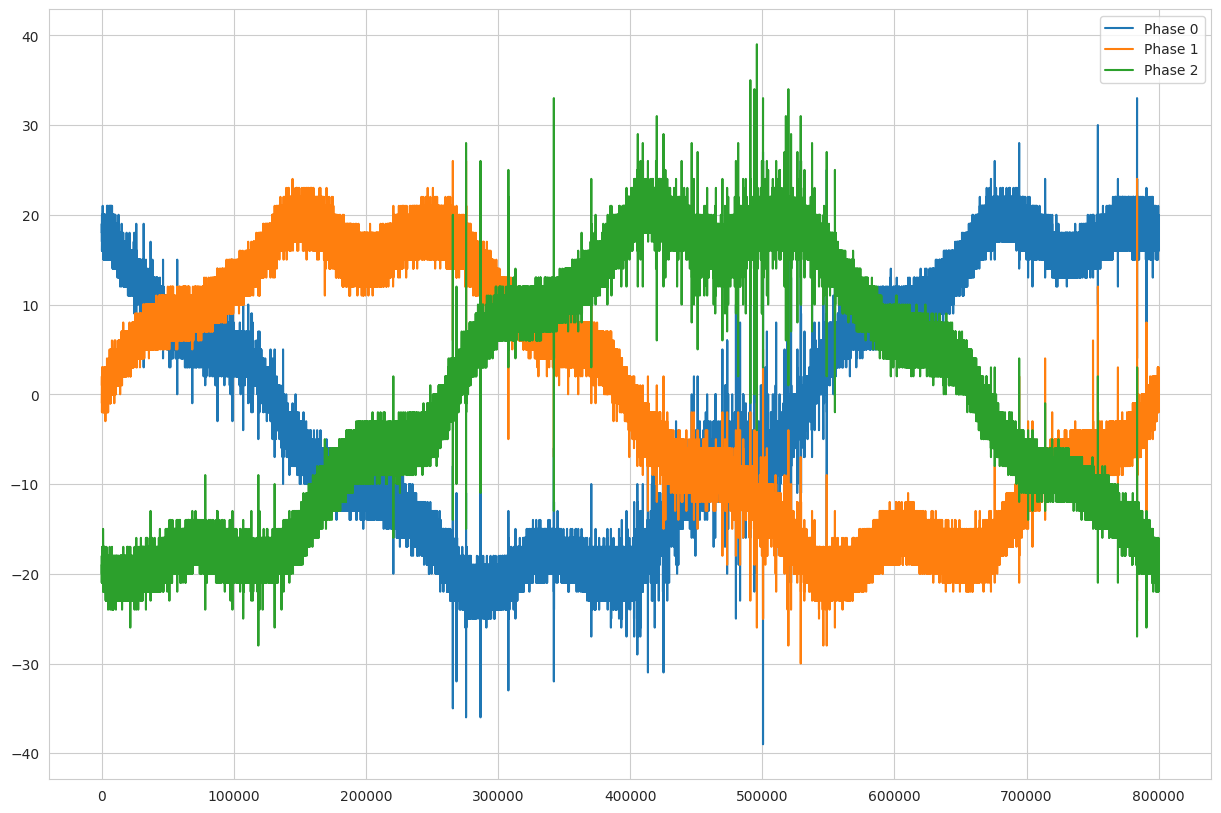

In [5]:
plt.figure(figsize=(15, 10))
plt.plot(signals[0, 0, :], label='Phase 0')
plt.plot(signals[0, 1, :], label='Phase 1')
plt.plot(signals[0, 2, :], label='Phase 2')
plt.legend()
plt.show()

## 2. Target

**2.1. Đọc dữ liệu từ file metadata_train.csv và hiển thị một vài dòng đầu tiên.**

In [6]:
train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/metadata_train.csv')
train_df.head()

,signal_id,id_measurement,phase,target
0,0,0,0,0
1,1,0,1,0
2,2,0,2,0
3,3,1,0,1
4,4,1,1,1


**2.2 Lấy cột 'target' từ DataFrame.**

Ở đây, nhóm chỉ lấy mỗi giá trị thứ ba (bắt đầu từ chỉ số 0). Mục đích làm giảm số lượng dữ liệu cần xử lý và phân tích.

In [7]:
target = train_df['target'][::3]
target

0       0
3       1
6       0
9       0
12      0
       ..
8697    0
8700    0
8703    0
8706    0
8709    0
Name: target, Length: 2904, dtype: int64

**2.3. Đếm số lượng Target và vẽ biểu đồ.**

- `value_counts()`: đếm số lượng mỗi giá trị duy nhất trong `target`, tức là đếm số lượng `target`là 0 và 1.

- Vẽ biểu đồ cột, trục x là chỉ số (0 và 1, tương ứng với không có lỗi và có lỗi); trục tung là số lượng của mỗi loại.







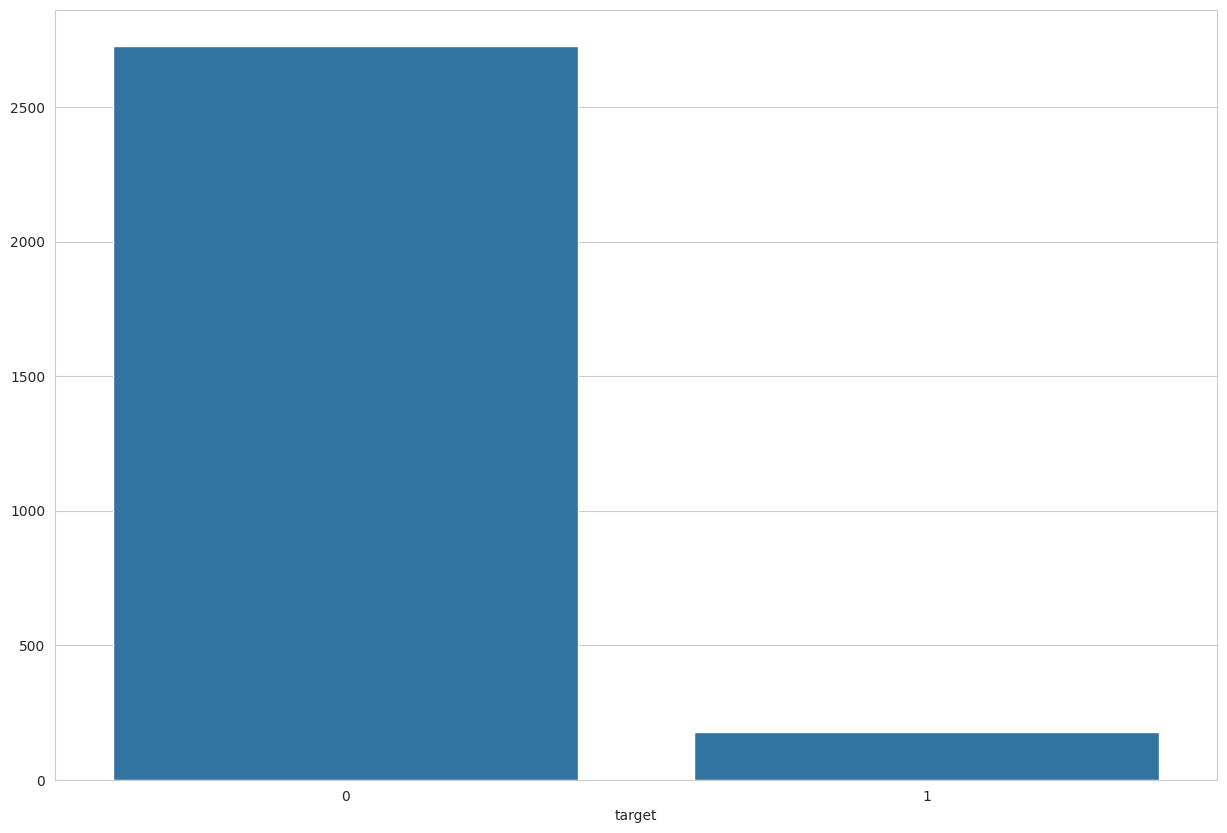

In [8]:
target_count = target.value_counts()
plt.figure(figsize=(15, 10))
sns.barplot(x=target_count.index, y=target_count.values)
plt.show()

##3. Smoothing by mean

Cho một tín hiệu ba chiều $X$ với các điểm dữ liệu $x_{ijk}$, trong đó $k$ là chỉ số thời gian, tín hiệu đầu ra $Y$ có thể được tính bằng công thức:

$
y_{ijm} = \frac{1}{n} \sum_{k=m \times n}^{(m+1) \times n - 1} x_{ijk}
$

trong đó:

$m$ là chỉ số của các điểm dữ liệu trong tín hiệu đầu ra.

$n$ là kích thước của kernel, tức là số lượng điểm dữ liệu trong mỗi phân đoạn được dùng để tính trung bình.

$y_{ijm}$ là giá trị trung bình của phân đoạn thứ $m$ của tín hiệu.

**3.1. Hàm sample: giảm độ phân giải theo thời gian của tín hiệu bằng cách thay thế `kernel_size` điểm liên tiếp bằng trung bình của chúng, làm mịn các biến động ngắn hạn và làm nổi bật các xu hướng lâu dài hơn trong data.**

- `def sample(signal, kernel_size)`: định nghĩa hàm với hai tham số, `signal` là mảng NumPy ba chiều chứa tín hiệu cần xử lý và `kernel_size` là số lượng điểm dữ liệu liên tiếp để tính trung bình cho mỗi điểm dữ liệu mới.

- `sampled = np.zeros((signal.shape[0], signal.shape[1], signal.shape[2]//kernel_size))`: khởi tạo một mảng NumPy mới có cùng số hàng và cột như `signal` nhưng có ít điểm dữ liệu hơn theo chiều thứ ba. Số lượng điểm dữ liệu mới này được tính bằng cách lấy tổng số điểm dữ liệu ban đầu (`signal.shape[2]`) chia cho `kernel_size`.

- `for i in range(signal.shape[2]//kernel_size)`: vòng lặp này chạy qua các phân đoạn của mảng `signal` dựa trên `kernel_size`. Với mỗi lần lặp, nó xác định một khối dữ liệu để tính trung bình.

- `begin = kernel_size * i` và `end = min(kernel_size * (i + 1), signal.shape[2])`: đây là các chỉ số bắt đầu và kết thúc của khối data hiện tại mà hàm sẽ tính trung bìnhh. Nếu `kernel_size` là 100, khối đầu tiên sẽ bao gồm các điểm từ chỉ số 0 đến 99, khối tiếp theo từ 100 đến 199, và cứ tiếp tục như vậy cho đến khi kết thúc mảng.

- `sampled[:, :, i] = np.mean(signal[:, :, begin:end], axis=2)`:  tính trung bình của `signal` trên khối được xác định (từ `begin` đến `end`) theo chiều thứ ba (`axis=2`) và lưu trữ kết quả vào mảng `sampled` tại vị trí tương ứng.

- `return sampled`: trả về mảng `sampled` chứa tín hiệu đã được làm mịn.

In [9]:
def sample(signal, kernel_size):
    sampled = np.zeros((signal.shape[0], signal.shape[1], signal.shape[2]//kernel_size))
    for i in range(signal.shape[2]//kernel_size):
        begin = kernel_size * i
        end = min(kernel_size * (i + 1), signal.shape[2])
        sampled[:, :, i] = np.mean(signal[:, :, begin:end], axis=2)
    return sampled

**3.2. Áp dụng Smoothing by mean cho `signals` với `kernal_size` là 100.**

Ở bước này:

1. Hàm `sample` sẽ được gọi với hai mảng `signals` và `100` làm kích thước kernel cho đường trung bình động.
2. Hàm sẽ tạo một mảng mới `sampled`, mảng này sẽ có cùng số hàng và cột như `signals`, nhưng độ dài của chiều thứ ba sẽ bị giảm đi 100 vì đường trung bình động được tính trên cứ 100 điểm của tín hiệu ban đầu.
3. Với mỗi bộ 100 điểm dọc theo chiều thứ ba của `signals`, hàm sẽ tính giá trị trung bình và lưu trữ ở vị trí tương ứng trong mảng `sampled`.
4. Cuối cùng, hàm sẽ trả về mảng `sampled`, hiện chứa tín hiệu đã được làm mịn.

In [10]:
sampled = sample(signals, 100)

**3.3. Đồ thị của của các tín hiệu sau khi được làm mịn:**


Sử dụng thư viện Matplotlib để vẽ biểu đồ các pha của tín hiệu đã được làm mịn.

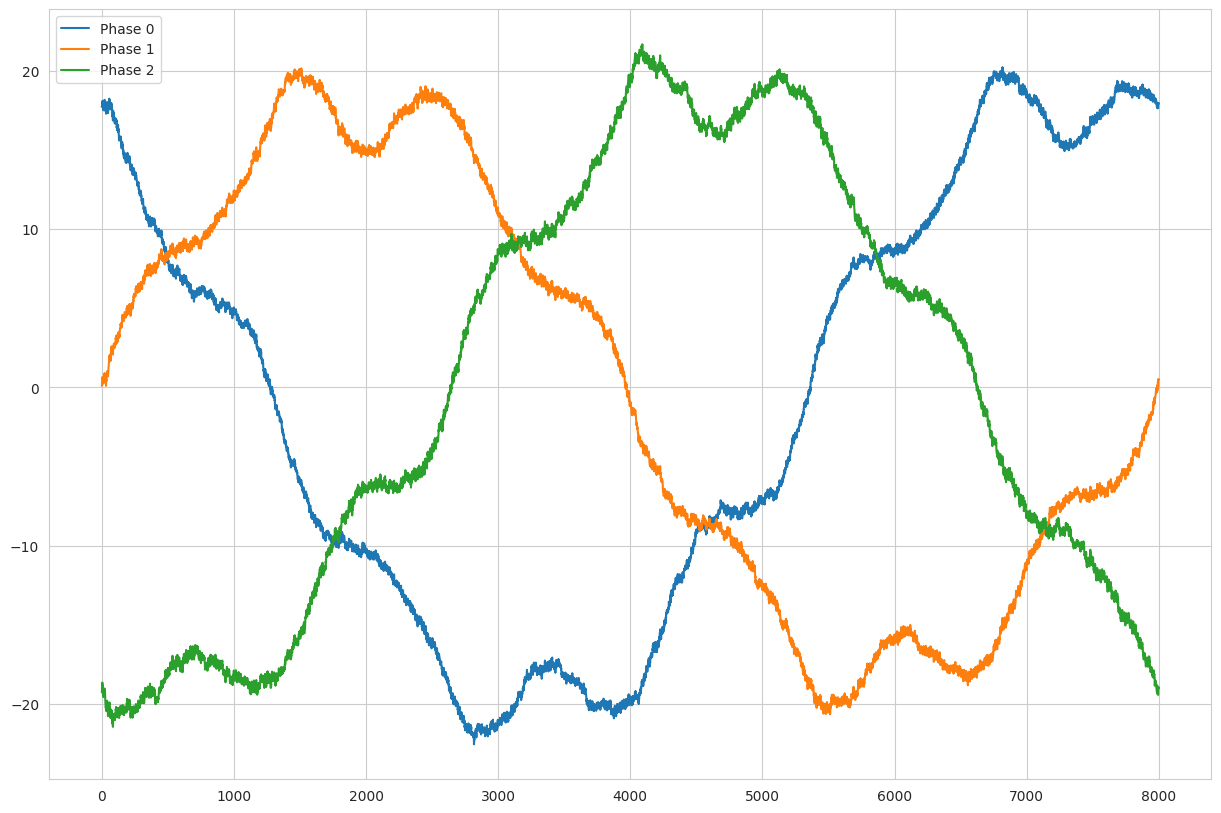

In [11]:
plt.figure(figsize=(15, 10))
plt.plot(sampled[0, 0, :], label='Phase 0')
plt.plot(sampled[0, 1, :], label='Phase 1')
plt.plot(sampled[0, 2, :], label='Phase 2')
plt.legend()
plt.show()

## 4. Song song hóa bước Smoothing by mean


**4.1. Hàm `sample_parallel` thực hiện việc làm mịn một mảng tín hiệu đa chiều thông qua phương pháp Moving Averages.**

- `@jit(nopython=True, parallel=True)`: một decorator từ thư viện Numba, biên dịch hàm sử dụng LLVM compiler framework. `nopython` đảm bảo rằng code chạy mà không cần GIL (Global Interpreter Lock) của Python, và `parallel=True` cho phép tự động song song hóa việc thực thi hàm.

- `def sample_parallel(signal, kernel_size)`: định nghĩa hàm với hai tham số là `signal`, một mảng NumPy chứa dữ liệu tín hiệu và `kernel_size`, một số nguyên biểu diễn kích thước của window mà trên đó tính toán giá trị trung bình.

- `new_length = signal.shape[2] // kernel_size`: tính toán xem có bao nhiêu windows có kích thước `kernel_size` vừa với chiều thứ ba của `signal`.

- `sampled = np.zeros((signal.shape[0], signal.shape[1], new_length), dtype=np.float32)`: khởi tạo một mảng mới NumPy kiểu `float32` để lưu trữ tín hiệu đã được làm mịn, với chiều thứ ba giảm xuống tương ứng với `new_length`.

- `for i in prange(new_length)`: lặp qua chiều dài mới của chiều thứ ba sử dụng `prange`, cho phép thực thi song song vòng lặp.

- Bên trong các vòng lặp lồng nhau qua `j` và `k`, lặp qua hai chiều đầu tiên của `signal` và ở đây:
   - Một biến tạm thời `segment_sum` được sử dụng để tính tổng các giá trị tín hiệu trong window hiện tại được định nghĩa bởi `begin` và `end`.
   - Trung bình của window hiện tại được tính toán thủ công bằng cách chia `segment_sum` cho số lượng phần tử trong window (được cho bởi `(end - begin)`).
   - Giá trị trung bình tính toán được gán vào vị trí tương ứng trong mảng `sampled`.

- `return sampled`: trả về mảng tín hiệu đã được làm mịn `sampled`.


In [12]:
from numba import jit, prange
import time

@jit(nopython=True, parallel=True)
def sample_parallel(signal, kernel_size):
    new_length = signal.shape[2] // kernel_size
    sampled = np.zeros((signal.shape[0], signal.shape[1], new_length), dtype=np.float32)  # Ensure dtype is float for mean calculation
    for i in prange(new_length):
        begin = kernel_size * i
        end = min(kernel_size * (i + 1), signal.shape[2])
        for j in range(signal.shape[0]):
            for k in range(signal.shape[1]):
                # Manually compute the mean to avoid issues with np.mean and datatypes in Numba
                segment_sum = 0.0
                for l in range(begin, end):
                    segment_sum += signal[j, k, l]
                segment_mean = segment_sum / (end - begin)
                sampled[j, k, i] = segment_mean
    return sampled

**4.2. So sánh thời gian thực thi của hai hàm xử lý tín hiệu.**


In [13]:
# Đo thời gian cho hàm sample
start_time_sample = time.time()
sampled = sample(signals, 100)
end_time_sample = time.time()
total_time_sample = end_time_sample - start_time_sample

print(f"Thời gian thực thi của hàm sample: {total_time_sample:.2f} giây")

#Đo thời gian cho hàm sample_parallel
# Note: cần "Warm up" cho hàm sample_parallel vì là lần đầu tiên chạy để tránh tính thời gian biên dịch numba vào thời gian thực thi.
sample_parallel(signals, 100)  # "Warm up" for Numba compilation

start_time_parallel = time.time()
sampled_parallel = sample_parallel(signals, 100)
end_time_parallel = time.time()
total_time_parallel = end_time_parallel - start_time_parallel

print(f"Thời gian thực thi của hàm sample_parallel: {total_time_parallel:.2f} giây")

Thời gian thực thi của hàm sample: 4.32 giây
Thời gian thực thi của hàm sample_parallel: 1.23 giây


# 5. Parallelize Fast Fourier Transform Denoising


**5.1. Công thức biến đổi Fourier của tín hiệu 1D $x$ có độ dài $n$ như sau:**

> $\mathscr{f}_j = \sum_{k=0}^{n-1} x_k e^{\frac{2\pi i}{n} jk} , ~~\forall j=0, ... , n-1$

Ý tưởng là biểu diễn tín hiệu trong không gian phức tạp. Nó đại khái là tổng của các hàm hình sin. Và có một hệ số cho mỗi tần số có trong tín hiệu.

Tần số nhận các giá trị sau:
- $f = \frac{1}{dn} [0, 1, \ldots , \frac{n}{2}-1, -\frac{n}{2}, \ldots , -1] $ if $ n$ là số chẵn
- $f =\frac{1}{dn} [0, 1, \ldots, \frac{n-1}{2}, -\frac{n-1}{2}, \ldots, -1] $ nếu $n$ là số lẻ

**Thuật toán khử nhiễu**

Các bước khử nhiễu như sau:
- Áp dụng FFT cho tín hiệu
- Tính tần số tương ứng với từng hệ số
- Chỉ giữ lại các hệ số có tần số đủ thấp (tuyệt đối)
- Tính toán FFT nghịch đảo

**5.2. Song song hóa hàm lọc nhiễu FFT.**

1. **Thêm thư viện cần thiết:**
- `numpy.fft`: Mô-đun này cung cấp các hàm để tính Biến đổi Fourier Nhanh (FFT) và ngược lại. Hàm `rfft` tính FFT của một đầu vào có giá trị thực, trả về các thành phần tần số không âm. `irfft` là hàm ngược của `rfft`, được sử dụng để chuyển đổi từ miền tần số trở lại thành miền thời gian. `rfftfreq` sinh ra các khoảng tần số cho một kích thước FFT đầu ra và khoảng mẫu đã cho.
- `numba`: Là một trình biên dịch Just-in-Time (JIT) chuyển một tập hợp con của mã Python và NumPy thành mã máy tốc độ cao. `njit` là một trình trang trí chỉ ra rằng Numba nên biên dịch hàm này trong chế độ no-Python, nơi hàm được biên dịch sao cho không truy cập vào các đối tượng Python.

2. **Định nghĩa các hàm được cải thiện bởi Numba:**
- `filter_frequencies`: Hàm này đặt các phần tử trong mảng biến đổi Fourier (`fourier`) về 0 nếu tần số tương ứng vượt quá một ngưỡng (`threshold`) nhất định. Điều này thường được thực hiện để loại bỏ nhiễu tần số cao trong tín hiệu.
- `filter_signal_parallel`: Hàm bao bọc gọi `filter_frequencies`. Nó được cấu trúc để có thể tận dụng khả năng xử lý song song của Numba để cải thiện hiệu suất.

3. **Load và định hình lại signal data:**
- Phần này của mã tải dữ liệu tín hiệu từ một tệp Parquet, đây là định dạng lưu trữ cột. Dữ liệu được tải vào một DataFrame pandas, sau đó chuyển đổi thành một mảng NumPy. Mảng được chuyển vị và định hình lại để tổ chức dữ liệu một cách có cấu trúc phù hợp cho việc xử lý. Ở đây, có vẻ như mỗi bộ ba cột tương ứng với ba pha của một tín hiệu, và mỗi pha chứa 800.000 điểm dữ liệu.

4. **Chọn signal và thực hiện FFT:**

- `signal`: Chọn pha đầu tiên của bộ tín hiệu đầu tiên.
- `fourier`: Tính biến đổi Fourier của tín hiệu đã chọn. Biến đổi này chuyển đổi tín hiệu miền thời gian thành các thành phần tần số của nó.
- `frequencies`: Tính các giá trị tần số tương ứng với mỗi phần tử trong mảng `fourier`, dựa trên kích thước tín hiệu và thời gian mẫu của tín hiệu (`d=20e-3` cho biết tổng thời gian mẫu tín hiệu là 20 mili giây).

Mục đích chung là tải một tập dữ liệu tín hiệu lớn, áp dụng Fast Fourier Transform để chuyển đổi nó thành miền tần số, lọc các tần số trên một ngưỡng nhất định để giảm nhiễu hoặc loại bỏ các thành phần tần số không mong muốn, và có thể sử dụng quá trình này cho phân tích hoặc tái tạo tín hiệu tiếp theo. Nhóm sử dụng Numba nhằm mục đích tối ưu hóa các thao tác này, đặc biệt hữu ích khi xử lý các tập dữ liệu lớn hoặc yêu cầu hiệu suất thời gian thực.

In [14]:
from numpy.fft import rfft, irfft, rfftfreq
from numba import njit

# Numba functions to filter frequencies based on threshold
@njit
def filter_frequencies(fourier, frequencies, threshold):
    for i in range(fourier.size):
        if frequencies[i] > threshold:
            fourier[i] = 0
    return fourier

@njit
def filter_signal_parallel(fourier, frequencies, threshold=1e8):
    return filter_frequencies(fourier, frequencies, threshold)

# Load the signal data
parquet_file_path = '/content/drive/MyDrive/Colab Notebooks/train.parquet'
signals_df = pq.read_table(parquet_file_path, columns=[str(i) for i in range(999)]).to_pandas()
signals = np.array(signals_df).T.reshape((999//3, 3, 800000))  # Reshape to 3 phases

# Select the first phase of the first signal
signal = signals[0, 0, :]

# Perform FFT
fourier = rfft(signal)
frequencies = rfftfreq(signal.size, d=20e-3/signal.size)

**5.2. Thử nghiệm với một vài thresholds.**

- Mục đích chính của việc áp dụng Fast Fourier Transform (FFT) để giảm nhiễu trong xử lý tín hiệu là để nâng cao chất lượng của tín hiệu bằng cách loại bỏ các thành phần tần số không mong muốn, thường là nhiễu. FFT là một công cụ mạnh mẽ cho phép chuyển đổi tín hiệu từ miền thời gian sang miền tần số, giúp dễ dàng phân tích và chỉnh sửa các thành phần tần số cụ thể của tín hiệu. Dưới đây là một số mục đích và lợi ích chính của việc sử dụng FFT để giảm nhiễu:
  - FFT cho phép xác định các thành phần tần số của tín hiệu, bao gồm cả tín hiệu mong muốn và nhiễu. Khi biết được thành phần tần số của nhiễu, có thể dễ dàng lọc hoặc giảm thiểu những tần số đó.
  - Các thành phần tần số cao thường là nhiễu trong nhiều loại tín hiệu như tín hiệu âm thanh, tín hiệu hình ảnh, và tín hiệu điện từ các thiết bị điện tử hoặc cơ sở hạ tầng. Việc sử dụng FFT để loại bỏ các tần số này giúp làm giảm nhiễu và cải thiện độ rõ nét của tín hiệu.
  - Tín hiệu sau khi được làm sạch từ nhiễu có độ chính xác cao hơn, làm cơ sở cho các phân tích tiếp theo và ra quyết định dựa trên dữ liệu. Điều này đặc biệt quan trọng trong các ứng dụng yêu cầu độ chính xác cao như y tế, tài chính, và an ninh.
  - Trong một số trường hợp, việc áp dụng FFT cho phép phát hiện các sự kiện đặc biệt như phóng điện một phần trong các đường dây điện, dấu hiệu của các hiện tượng thiên nhiên trong dữ liệu thủy văn hoặc khí tượng, hoặc các dấu hiệu bệnh lý trong tín hiệu y tế.
  - Bằng cách loại bỏ nhiễu và các thành phần tần số không cần thiết, FFT giúp giảm băng thông cần thiết cho việc truyền tải tín hiệu và giảm yêu cầu về không gian lưu trữ, qua đó tối ưu hóa hiệu quả của các hệ thống xử lý và truyền dữ liệu.

- Ý tưởng giải quyết khi thực nghiệm trên một vài Thresholds, và ở đây nhóm test trên các ngưỡng như: 1e3, 1e5, 1e7, 1e10.
  - Đặt ngưỡng: ngưỡng được đặt để kiểm soát việc loại bỏ nhiễu. Ngưỡng này cho phép loại bỏ các thành phần tần số mà có giá trị nhỏ hơn ngưỡng này, được xem là nhiễu hoặc không quan trọng đối với tín hiệu gốc.
  - Lọc fourier: `filter_signal_parallel` sử dụng biến đổi Fourier đã tính trước (fourier) và tần số (frequencies) để áp dụng ngưỡng. Trong hàm này, các thành phần tần số cao hơn ngưỡng được đặt thành không, nhằm giảm nhiễu trong tín hiệu.
  - Biến đổi Fourier ngược: sau khi các thành phần tần số không mong muốn đã được loại bỏ, `irfft` (Biến đổi Fourier ngược cho tín hiệu thực) được sử dụng để chuyển dữ liệu trở lại từ miền tần số sang miền thời gian, tạo ra tín hiệu đã được lọc.

In [15]:
# Áp dụng threshold = 1e3
threshold = 1e3  # Lower threshold for testing
filtered_fourier = filter_signal_parallel(fourier, frequencies, threshold)
filtered_signal = irfft(filtered_fourier)

**Phân tích tín hiệu:**
- Tín hiệu gốc ("Raw"): được biểu diễn bằng đường màu xanh lam, có biến động mạnh về biên độ và chứa nhiều nhiễu, nhất là các đỉnh sắc và đột biến tần số cao. Những đỉnh này là điển hình cho nhiễu hoặc biến động không mong muốn trong tín hiệu.
- Tín hiệu đã lọc ("Filtered"): đường màu cam thể hiện tín hiệu sau khi đã lọc, nó mượt mà hơn rõ rệt và ít biến động hơn so với tín hiệu gốc. Điều này cho thấy quá trình giảm nhiễu đã hiệu quả trong việc loại bỏ các thành phần tần số cao mà có thể được coi là nhiễu.


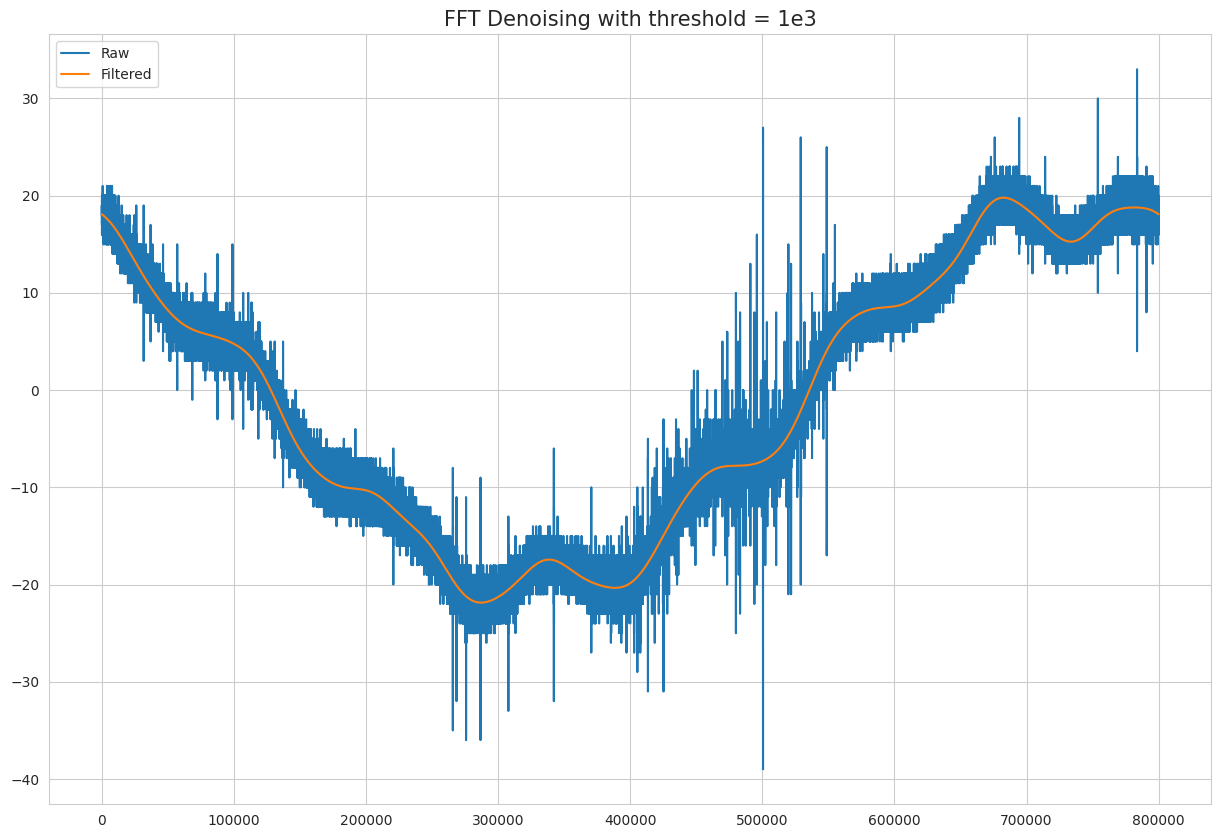

In [16]:
# Plot the original and filtered signals
plt.figure(figsize=(15, 10))
plt.plot(signal, label='Raw')
plt.plot(filtered_signal, label='Filtered')
plt.legend()
plt.title("FFT Denoising with threshold = 1e3", size=15)
plt.show()

**Đánh giá ngưỡng 1e3:**
- Ngưỡng 1e3 đã giúp làm giảm đáng kể các nhiễu tần số cao trong khi vẫn giữ được hình dáng chung của tín hiệu. Tuy nhiên, vẫn có một số biến động nhỏ không được lọc hết, cho thấy ngưỡng này có thể không đủ cao để lọc sạch hoàn toàn nhiễu nhưng vẫn giữ được phần lớn thông tin cần thiết của tín hiệu.
- Tín hiệu đã lọc mượt mà hơn nhiều so với tín hiệu gốc, điều này có thể rất hữu ích trong các ứng dụng yêu cầu độ rõ nét cao và giảm thiểu sự can thiệp của nhiễu, như xử lý tín hiệu âm thanh hoặc tín hiệu y tế.

In [17]:
# Áp dụng threshold 1e5
fourier = rfft(signal) # Recompute the fourier transform to reset it
frequencies = rfftfreq(signal.size, d=20e-3/signal.size)
threshold = 1e5 # Higher threshold for testing
filtered_fourier = filter_signal_parallel(fourier, frequencies, threshold)
filtered_signal = irfft(filtered_fourier)

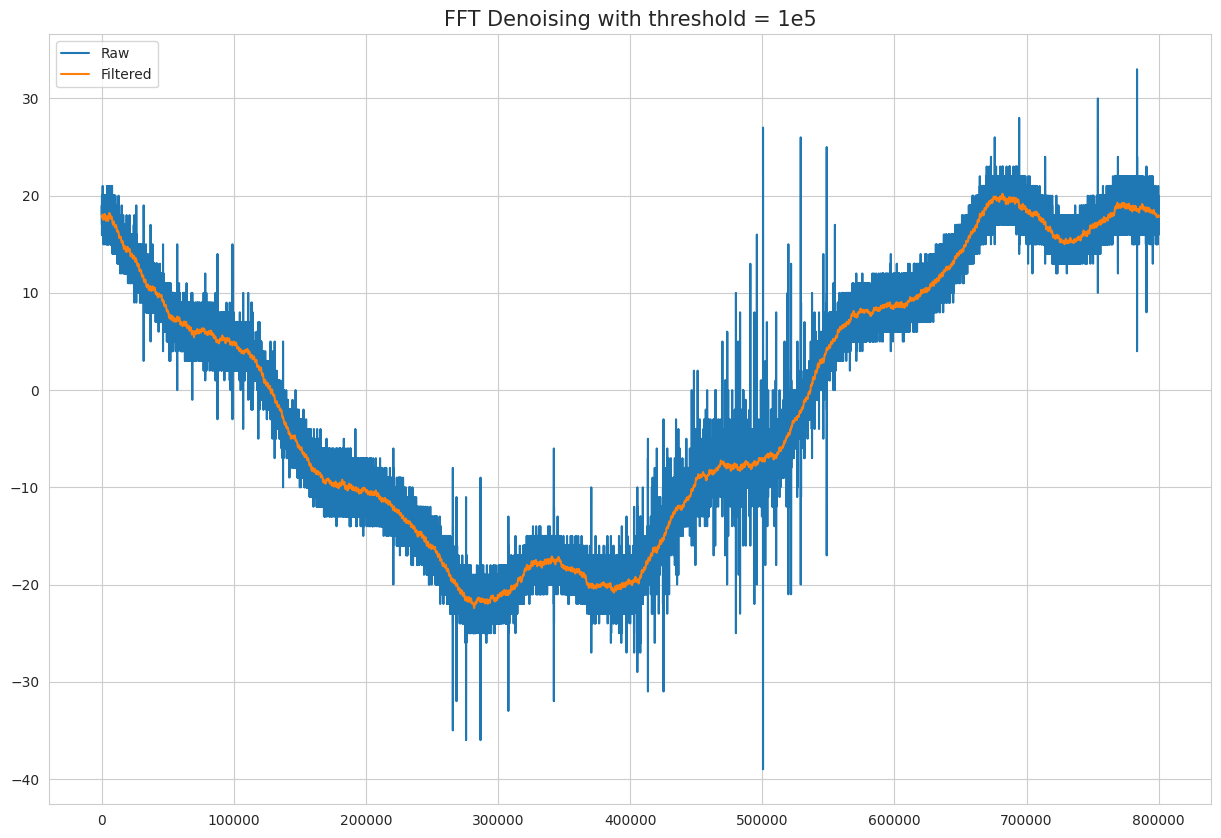

In [18]:
# Plot the original and filtered signals
plt.figure(figsize=(15, 10))
plt.plot(signal, label='Raw')
plt.plot(filtered_signal, label='Filtered')
plt.legend()
plt.title("FFT Denoising with threshold = 1e5", size=15)
plt.show()

**Đánh giá ngưỡng 1e5:**

- Hiệu quả trong việc loại bỏ nhiều nhiễu, đặc biệt là các thành phần nhiễu có tần số cao. Tín hiệu đã lọc thể hiện sự ổn định hơn nhiều so với tín hiệu gốc, điều này là lợi ích trong hầu hết các ứng dụng yêu cầu độ rõ nét cao và ít nhiễu.

- Tín hiệu đã lọc vẫn giữ được hình dáng cơ bản của tín hiệu gốc, điều này cho thấy ngưỡng được sử dụng đã loại bỏ nhiễu mà không làm mất đi thông tin quan trọng của tín hiệu. Tuy nhiên, vẫn có thể thấy một số biến động nhỏ trong tín hiệu đã lọc, cho thấy rằng không phải tất cả nhiễu đã được loại bỏ hoàn toàn.

In [19]:
# Áp dụng threshold 1e7
fourier = rfft(signal) # Recompute the fourier transform to reset it
frequencies = rfftfreq(signal.size, d=20e-3/signal.size)
threshold = 1e7  # Higher threshold for testing
filtered_fourier = filter_signal_parallel(fourier, frequencies, threshold)
filtered_signal = irfft(filtered_fourier)

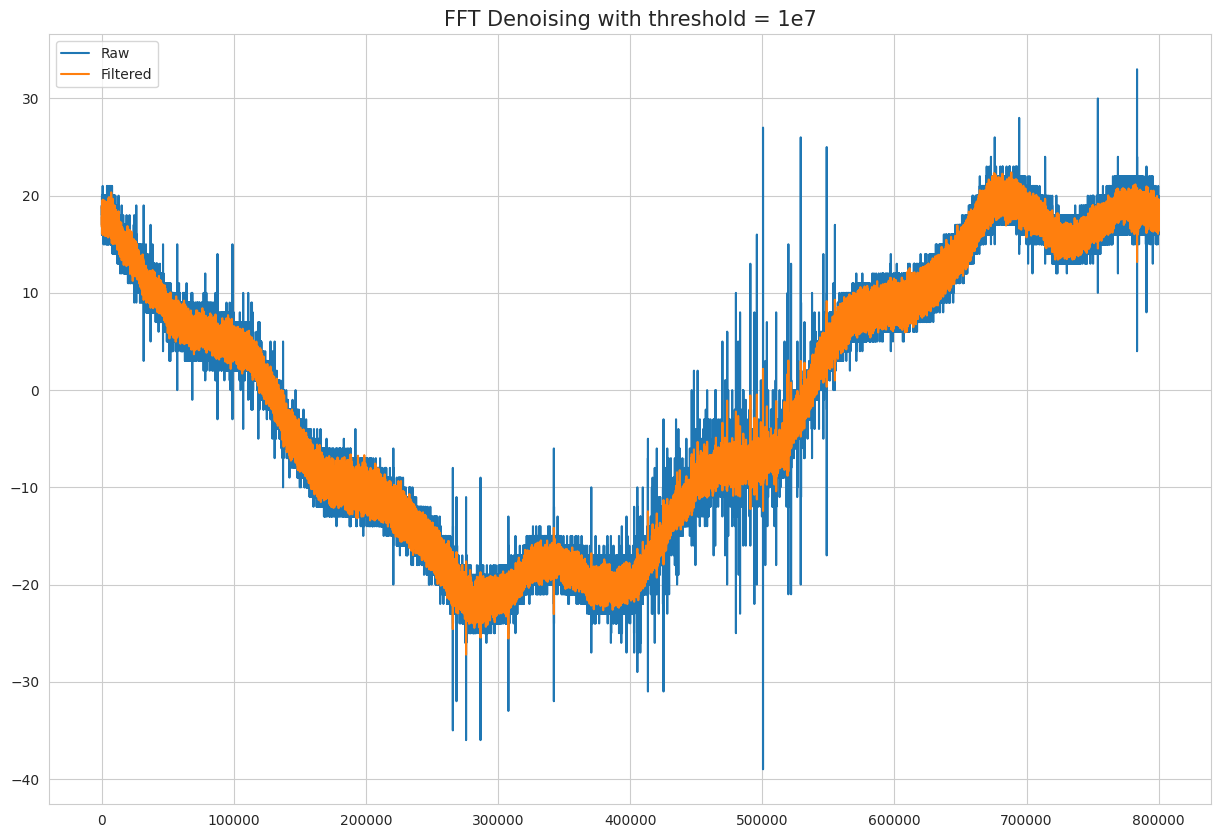

In [20]:
# Plot the original and filtered signals
plt.figure(figsize=(15, 10))
plt.plot(signal, label='Raw')
plt.plot(filtered_signal, label='Filtered')
plt.legend()
plt.title("FFT Denoising with threshold = 1e7", size=15)
plt.show()

**Đánh giá ngưỡng 1e7:**

- Ta có thể thấy ngưỡng 1e7 rõ ràng chỉ hiệu quả hơn một ít trong việc loại bỏ nhiễu, giúp tín hiệu đã lọc trở nên mượt mà hơn khá nhiều so với tín hiệu gốc.
- Mặc dù tín hiệu đã lọc trơn tru hơn, nhưng cần phải cẩn trọng để đảm bảo việc không loại bỏ quá nhiều thông tin tín hiệu quan trọng. Việc sử dụng một ngưỡng cao như 1e7 có thể dẫn đến việc một số đặc điểm của tín hiệu bị mất, đặc biệt là trong các tần số cao có chứa thông tin có giá trị.

In [21]:
# Áp dụng threshold 1e10
fourier = rfft(signal) # Recompute the fourier transform to reset it
frequencies = rfftfreq(signal.size, d=20e-3/signal.size)
threshold = 1e10  # Higher threshold for testing
filtered_fourier = filter_signal_parallel(fourier, frequencies, threshold)
filtered_signal = irfft(filtered_fourier)

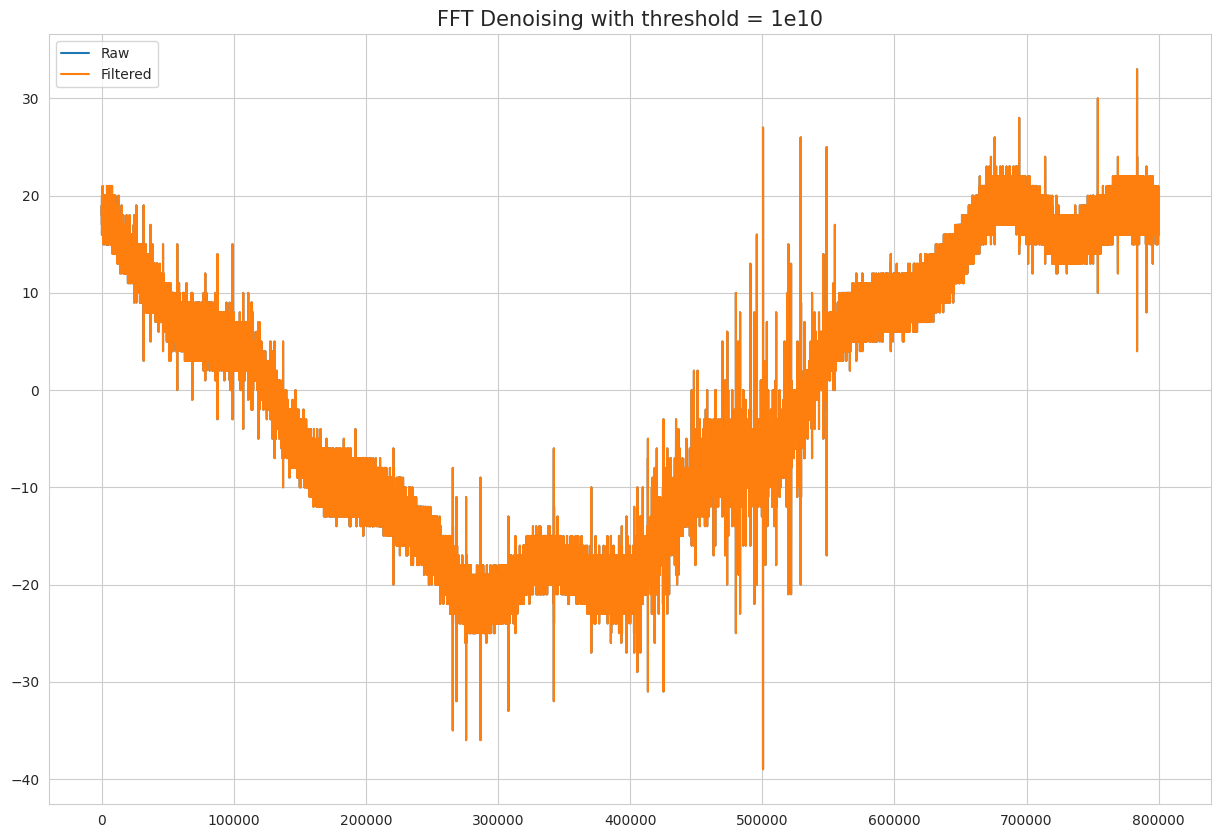

In [22]:
# Plot the original and filtered signals
plt.figure(figsize=(15, 10))
plt.plot(signal, label='Raw')
plt.plot(filtered_signal, label='Filtered')
plt.legend()
plt.title("FFT Denoising with threshold = 1e10", size=15)
plt.show()

**Đánh giá ngưỡng 1e10:**
- Qua quan sát ta có thể thấy ngưỡng 1e10 quá cao, dẫn đến việc loại bỏ gần như toàn bộ các thành phần tần số của tín hiệu. Điều này có thể không còn giữ lại đủ thông tin từ tín hiệu gốc, khiến cho tín hiệu sau khi lọc không còn bất kỳ biến động đáng kể nào so với tín hiệu gốc.
- Sử dụng một ngưỡng cao có thể dẫn đến mất mát các thông tin quan trọng trong tín hiệu, đặc biệt là khi các thông tin này có tần số không cao tới mức ngưỡng đã đặt.

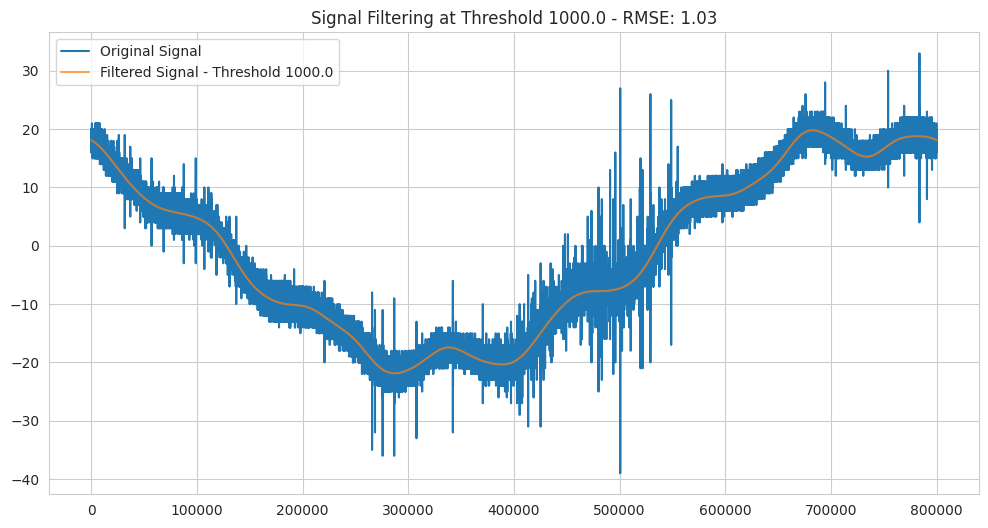

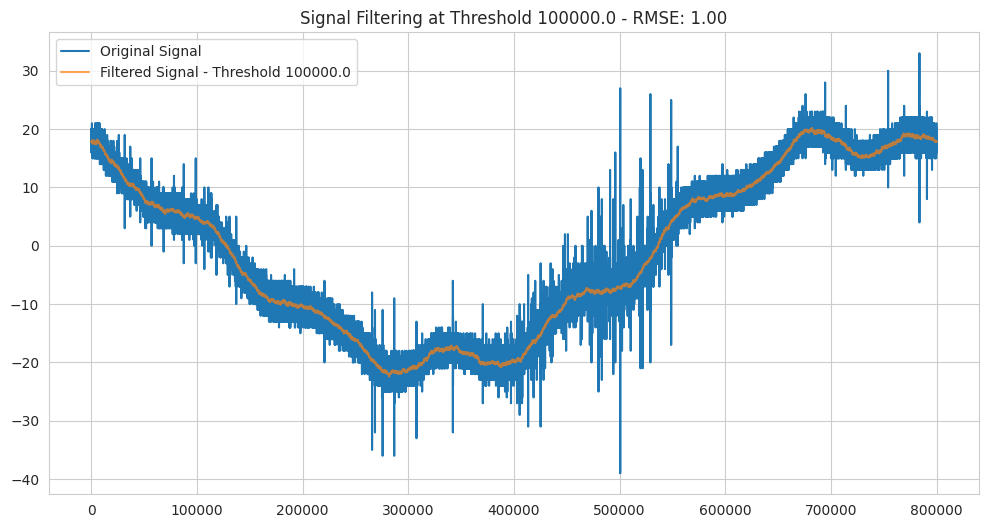

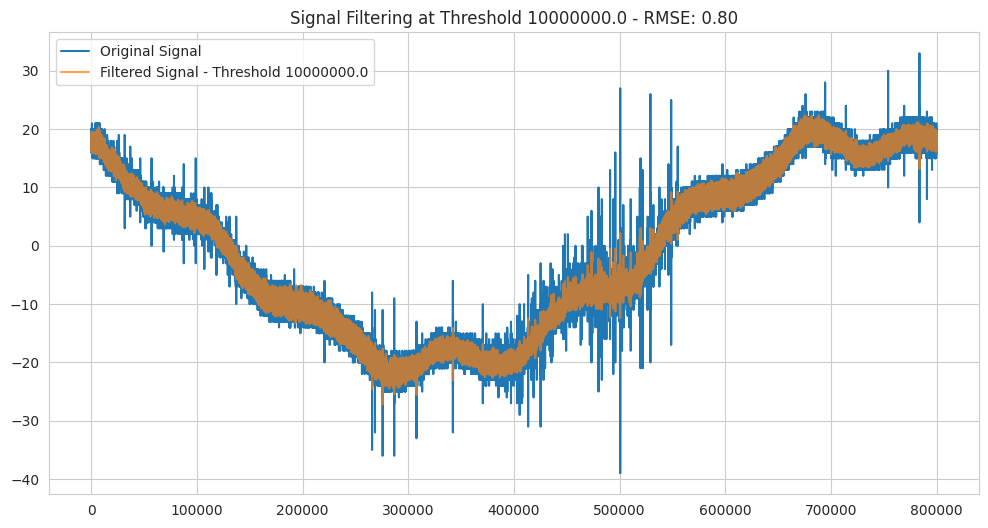

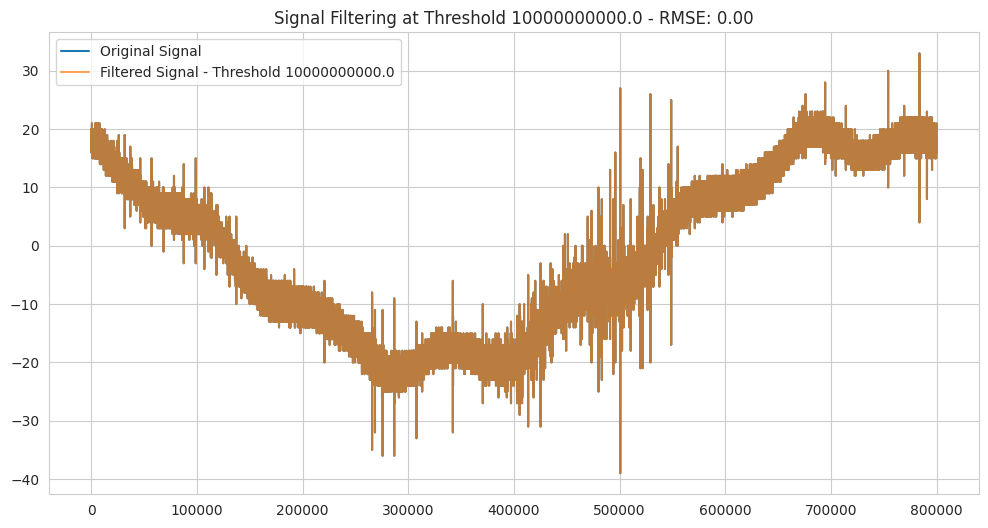

Threshold 1000.0: RMSE = 1.03
Threshold 100000.0: RMSE = 1.00
Threshold 10000000.0: RMSE = 0.80
Threshold 10000000000.0: RMSE = 0.00


In [23]:
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
from numpy.fft import rfft, irfft, rfftfreq
import matplotlib.pyplot as plt
from numba import njit

# Đọc dữ liệu
parquet_file_path = '/content/drive/MyDrive/Colab Notebooks/train.parquet'
signals_df = pq.read_table(parquet_file_path, columns=[str(i) for i in range(999)]).to_pandas()
signals = np.array(signals_df).T.reshape((999//3, 3, 800000))  # Reshape thành 3 phases

# Chọn tín hiệu gốc từ phase 0 của tín hiệu đầu tiên để đánh giá
original_signal = signals[0, 0, :]

# Numba function to filter frequencies based on threshold
@njit
def filter_frequencies(fourier, frequencies, threshold):
    for i in range(fourier.size):
        if frequencies[i] > threshold:
            fourier[i] = 0
    return fourier

@njit
def filter_signal(fourier, frequencies, threshold):
    return filter_frequencies(fourier, frequencies, threshold)

def calculate_rmse(original, filtered):
    return np.sqrt(np.mean((original - filtered) ** 2))

# Mảng lưu RMSE cho từng ngưỡng
thresholds = [1e3, 1e5, 1e7, 1e10]
rmse_results = {}

for threshold in thresholds:
    fourier = rfft(original_signal)
    frequencies = rfftfreq(original_signal.size, d=20e-3/original_signal.size)
    filtered_fourier = filter_signal(fourier, frequencies, threshold)
    filtered_signal = irfft(filtered_fourier)

    rmse = calculate_rmse(original_signal, filtered_signal)
    rmse_results[threshold] = rmse

    # In và vẽ biểu đồ kết quả
    plt.figure(figsize=(12, 6))
    plt.plot(original_signal, label='Original Signal')
    plt.plot(filtered_signal, label=f'Filtered Signal - Threshold {threshold}', alpha=0.7)
    plt.title(f"Signal Filtering at Threshold {threshold} - RMSE: {rmse:.2f}")
    plt.legend()
    plt.show()

# In kết quả RMSE
for thresh, error in rmse_results.items():
    print(f"Threshold {thresh}: RMSE = {error:.2f}")


Thresholds thấp (1000 và 100000): Những ngưỡng này không lọc bỏ đủ nhiễu trong tín hiệu, do đó tín hiệu sau khi lọc vẫn chứa nhiều thành phần nhiễu. Điều này dẫn đến giá trị RMSE cao hơn, cho thấy sự khác biệt đáng kể giữa tín hiệu gốc và tín hiệu đã lọc.

Threshold 10000000.0: Ngưỡng này hiệu quả hơn trong việc loại bỏ nhiễu, làm giảm RMSE xuống còn 0.80. Điều này cho thấy tín hiệu đã lọc gần với tín hiệu gốc hơn so với các ngưỡng thấp hơn.

Threshold 10000000000.0: RMSE = 0.00 chỉ ra rằng tín hiệu sau khi lọc hoàn toàn không có sự khác biệt so với tín hiệu gốc. Điều này có thể xảy ra nếu ngưỡng lọc quá cao, khiến tất cả các thành phần tần số bị loại bỏ hoặc không còn phần nhiễu nào còn lại trong tín hiệu. Tuy nhiên, điều này cũng có thể dẫn đến việc mất mát thông tin quan trọng của tín hiệu, nếu tín hiệu thực sự có thành phần tần số cao có ý nghĩa.



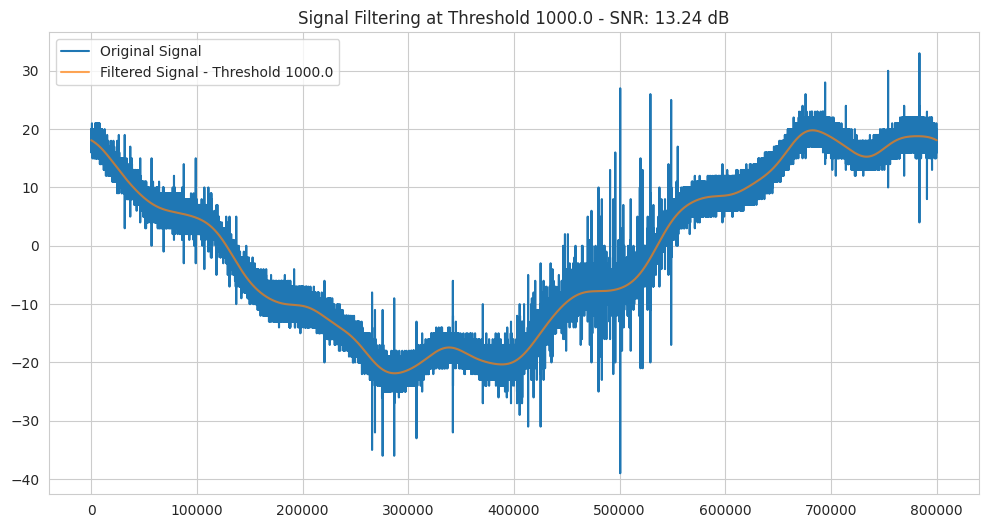

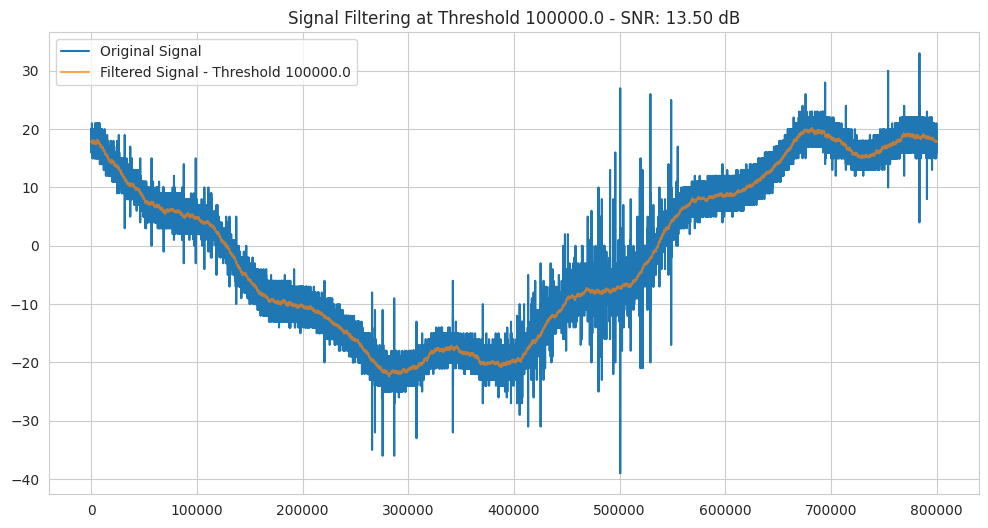

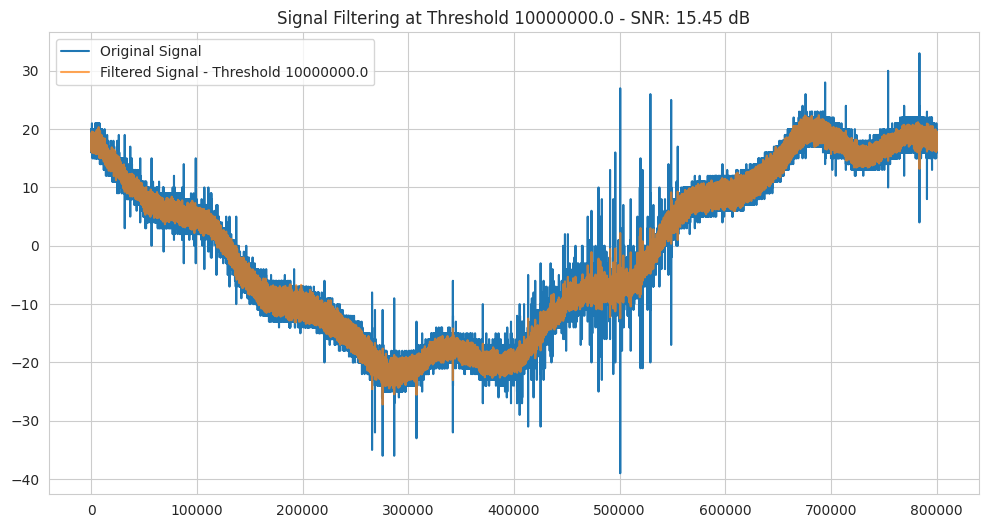

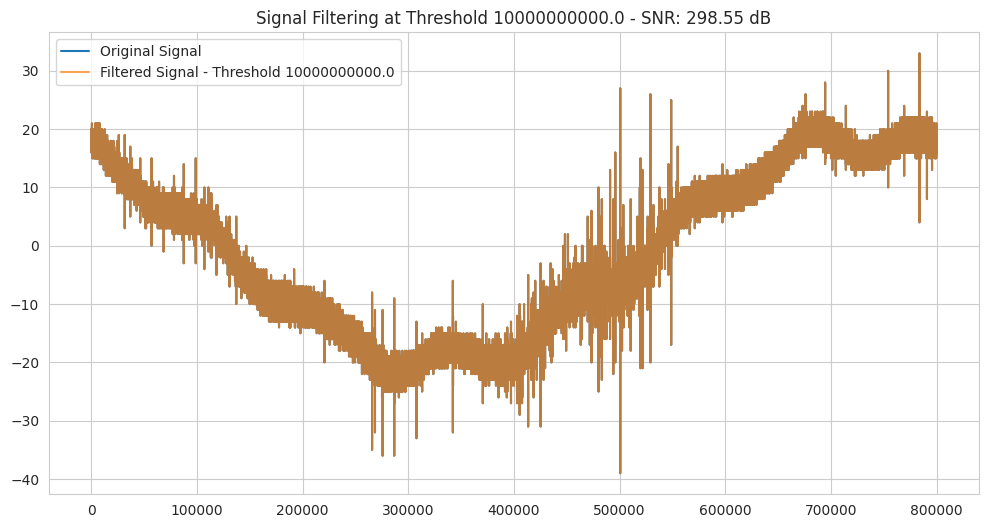

Threshold 1000.0: SNR = 13.24 dB
Threshold 100000.0: SNR = 13.50 dB
Threshold 10000000.0: SNR = 15.45 dB
Threshold 10000000000.0: SNR = 298.55 dB


In [27]:
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
from numpy.fft import rfft, irfft, rfftfreq
import matplotlib.pyplot as plt
from numba import njit

# Đọc dữ liệu
parquet_file_path = '/content/drive/MyDrive/Colab Notebooks/train.parquet'
signals_df = pq.read_table(parquet_file_path, columns=[str(i) for i in range(999)]).to_pandas()
signals = np.array(signals_df).T.reshape((999//3, 3, 800000))  # Reshape thành 3 phases

original_signal = signals[0, 0, :]

@njit
def filter_frequencies(fourier, frequencies, threshold):
    for i in range(fourier.size):
        if frequencies[i] > threshold:
            fourier[i] = 0
    return fourier

@njit
def filter_signal(fourier, frequencies, threshold):
    return filter_frequencies(fourier, frequencies, threshold)

def calculate_snr(original, filtered):
    signal_power = np.mean(original ** 2)
    noise_power = np.mean((original - filtered) ** 2)
    return 10 * np.log10(signal_power / noise_power)

# Mảng lưu SNR cho từng ngưỡng
thresholds = [1e3, 1e5, 1e7, 1e10]
snr_results = {}

for threshold in thresholds:
    fourier = rfft(original_signal)
    frequencies = rfftfreq(original_signal.size, d=20e-3/original_signal.size)
    filtered_fourier = filter_signal(fourier, frequencies, threshold)
    filtered_signal = irfft(filtered_fourier)

    # Tính SNR và lưu vào dictionary
    snr = calculate_snr(original_signal, filtered_signal)
    snr_results[threshold] = snr

    # In và vẽ biểu đồ kết quả
    plt.figure(figsize=(12, 6))
    plt.plot(original_signal, label='Original Signal')
    plt.plot(filtered_signal, label=f'Filtered Signal - Threshold {threshold}', alpha=0.7)
    plt.title(f"Signal Filtering at Threshold {threshold} - SNR: {snr:.2f} dB")
    plt.legend()
    plt.show()

# In kết quả SNR
for thresh, snr_value in snr_results.items():
    print(f"Threshold {thresh}: SNR = {snr_value:.2f} dB")


1. **Ngưỡng 1,000 (1e3)**: SNR = 13.24 dB
   - cung cấp một mức độ giảm nhiễu vừa phải. SNR tương đối thấp, cho thấy mặc dù một số nhiễu được loại bỏ, nhưng vẫn còn khá nhiều nhiễu.

2. **Ngưỡng 100,000 (1e5)**: SNR = 13.50 dB
   - tăng nhẹ về SNR so với 1e3 cho thấy việc khử nhiễu tốt hơn một chút. Nhưng sự cải thiện không đáng kể, cho thấy đặc tính nhiễu không khác biệt nhiều ở ngưỡng này.

3. **Ngưỡng 10,000,000 (1e7)**: SNR = 15.45 dB
   - Ngưỡng này cung cấp một sự cân bằng tốt hơn giữa việc giảm nhiễu và bảo toàn tính toàn vẹn của tín hiệu. Cho thấy khả năng khử nhiễu hiệu quả hơn trong khi vẫn giữ lại các đặc điểm cần thiết của tín hiệu.

4. **Ngưỡng 10,000,000,000 (1e10)**: SNR = 298.55 dB
   - SNR cực kỳ cao này cho thấy hầu như tất cả nhiễu đã được loại bỏ, tạo ra một tín hiệu rất sạch. Tuy nhiên, SNR cao như vậy cũng có thể cho thấy tín hiệu đã bị khử nhiễu quá mức, có khả năng loại bỏ cả những đặc điểm quan trọng của tín hiệu cùng với nhiễu. Ngưỡng này có thể đang loại bỏ quá nhiều nội dung tín hiệu, không chỉ là nhiễu, đặc biệt trong các ứng dụng thực tế nơi mà chi tiết tín hiệu là rất quan trọng.

Xét về kết quả này, sự lựa chọn ngưỡng tối ưu phụ thuộc vào yêu cầu cụ thể của nhiệm vụ xử lý tín hiệu cho từng mục đích riêng:
- Nếu việc bảo toàn chi tiết tín hiệu càng nhiều càng tốt là rất quan trọng, thì ngưỡng khoảng **1e7** có thể cung cấp sự cân bằng tốt nhất giữa việc giảm nhiễu và bảo toàn tín hiệu.
- Nếu nhiệm vụ yêu cầu tín hiệu cực kỳ sạch và có thể chấp nhận một số mất mát chi tiết tín hiệu, thì ngưỡng cao hơn như **1e10** có thể xem xét.



**5.3. So sánh hàm tuần tự FFT và hàm FFT sau khi song song hóa khi thử nghiệm trên threshold 1e5:**

In [25]:
import numpy as np
from numpy.fft import rfft, irfft, rfftfreq
import pyarrow.parquet as pq
import time

def filter_signals(signals, threshold=1e8):
    filtered_signals = np.empty_like(signals)  # Mảng để lưu các tín hiệu đã được lọc

    # Xử lý từng tín hiệu một trong batch
    for i in range(signals.shape[0]):
        signal = signals[i]
        fourier = rfft(signal)
        frequencies = rfftfreq(signal.size, d=20e-3/signal.size)
        fourier[frequencies > threshold] = 0
        filtered_signals[i] = irfft(fourier)

    return filtered_signals

# Load data
parquet_file_path = '/content/drive/MyDrive/Colab Notebooks/train.parquet'
signals_df = pq.read_table(parquet_file_path, columns=[str(i) for i in range(999)]).to_pandas()
signals = np.array(signals_df).T.reshape((999//3, 3, 800000))

# Chọn 333 tín hiệu
batch_signals = signals[:200, 0, :]
start_time = time.time()
filtered_batch_signals = np.array([filter_signal(signal, threshold=1e5) for signal in batch_signals])
end_time = time.time()
print(f"Execution time for sequential processing of {len(batch_signals)} signals: {end_time - start_time:.5f} seconds")

Execution time of sequential function: 0.06187 seconds
Execution time of sequential function: 0.06426 seconds
Execution time of sequential function: 0.08146 seconds
Execution time of sequential function: 0.06314 seconds
Execution time of sequential function: 0.08013 seconds
Execution time of sequential function: 0.05808 seconds
Execution time of sequential function: 0.08480 seconds
Execution time of sequential function: 0.08557 seconds
Execution time of sequential function: 0.06308 seconds
Execution time of sequential function: 0.07130 seconds
Execution time of sequential function: 0.06259 seconds
Execution time of sequential function: 0.05965 seconds
Execution time of sequential function: 0.09118 seconds
Execution time of sequential function: 0.05948 seconds
Execution time of sequential function: 0.16420 seconds
Execution time of sequential function: 0.06927 seconds
Execution time of sequential function: 0.06641 seconds
Execution time of sequential function: 0.07177 seconds
Execution 

In [26]:
from numba import cuda
import numpy as np
from numpy.fft import rfft, irfft, rfftfreq
import pyarrow.parquet as pq
import time

@cuda.jit
def filter_frequencies_cuda(fourier, frequencies, threshold):
    idx = cuda.grid(1)  # Lấy chỉ số của thread trong grid
    if idx < fourier.size:
        if frequencies[idx] > threshold:
            fourier[idx] = 0

def filter_signal_cuda(signal, threshold=1e8):
    fourier = rfft(signal)
    frequencies = rfftfreq(signal.size, d=20e-3/signal.size)

    # Chuyển dữ liệu lên GPU
    d_fourier = cuda.to_device(fourier)
    d_frequencies = cuda.to_device(frequencies)

    # Gọi kernel
    threads_per_block = 256
    blocks_per_grid = (fourier.size + (threads_per_block - 1)) // threads_per_block
    filter_frequencies_cuda[blocks_per_grid, threads_per_block](d_fourier, d_frequencies, threshold)

    # Chuyển kết quả từ GPU về CPU và thực hiện IFFT trên CPU
    return irfft(d_fourier.copy_to_host())

# Load dữ liệu tín hiệu
parquet_file_path = '/content/drive/MyDrive/Colab Notebooks/train.parquet'
signals_df = pq.read_table(parquet_file_path, columns=[str(i) for i in range(999)]).to_pandas()
signals = np.array(signals_df).T.reshape((999//3, 3, 800000))
batch_signals = signals[:200, 0, :]

# Warm-up bằng cách gọi hàm một lần trước khi đo thời gian
warmup_signal = signals[0, 0, :]
filter_signal_cuda(warmup_signal, threshold=1e5)

# Áp dụng
start_time = time.time()
filtered_signals_cuda = np.array([filter_signal_cuda(signal, threshold=1e5) for signal in batch_signals])
end_time = time.time()
print(f"Execution time with CUDA after warm-up: {end_time - start_time:.5f} seconds")

Execution time with CUDA after warm-up: 7.90753 seconds


vẫn cần chuyển fourier trở lại CPU để thực hiện irfft vì Numba chưa hỗ trợ thực hiện IFFT trên GPU.